# Data Preparation

Combining the original data and the user data, cleaning up the resulting data set, and performing some exploration of the results.

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Cosmetics

sns.set_style('darkgrid')

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Data Extraction

Combine the three user data dataframes into one:

In [9]:
userDataDFPartition1 = pd.read_pickle('data/user_data_0_30000.pkl')
userDataDFPartition2 = pd.read_pickle('data/personal_finance_user_data_30000_60000.pkl')
userDataDFPartition3 = pd.read_pickle('data/personal_finance_user_data_60000_end.pkl')
userDataFullDF = pd.concat([userDataDFPartition1, userDataDFPartition2, userDataDFPartition3])

Combine user data with post data in the training set. Just to confirm the merge worked as expected, we check if the Author cols from user and post data line up.

In [10]:
postDF = pd.read_pickle('data/train.pkl')
trainDF = postDF.reset_index(drop=True).merge(userDataFullDF.reset_index(drop=True), left_index=True, right_index=True)
assert trainDF['Author'].equals(trainDF['author'])
df = trainDF

## Cleaning

Remove duplicated author information, give more verbose names to user features, and add columns for the length of the title and selftext:

In [11]:
df.drop('Author', axis=1, inplace=True)
df.columns = ['id', 'author', 'title', 'selftext', 'time', 'date', 
                   'score', 'num_comments', 'user_account_created', 'num_user_comments', 
                   'median_user_comment_score', 'max_user_comment_score', 
                   'num_user_submissions', 'median_user_submission_score', 
                   'max_user_submission_score']

### User Data Cleaning

We observe the user data has a lot of NA values. Around half of the users have no entries for the median/max scores for their previous comments and submissions:

In [12]:
df = df.replace('NA', np.NaN)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124941 entries, 0 to 124940
Data columns (total 15 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            124941 non-null  object 
 1   author                        124941 non-null  object 
 2   title                         124941 non-null  object 
 3   selftext                      124145 non-null  object 
 4   time                          124941 non-null  object 
 5   date                          124941 non-null  object 
 6   score                         124941 non-null  int64  
 7   num_comments                  124941 non-null  int64  
 8   user_account_created          115213 non-null  float64
 9   num_user_comments             124941 non-null  int64  
 10  median_user_comment_score     64968 non-null   float64
 11  max_user_comment_score        64968 non-null   float64
 12  num_user_submissions          124941 non-nul

If `num_user_comments` is 0, then `median_user_comment_score` and `max_user_comment_score` are 'NA' (the same is true for the user's submissions). We shall replace them with 0, as this seems sensible (i.e., define the median and maximum of a set of 0 numbers to be 0).

In [13]:
df[['median_user_comment_score', 
         'max_user_comment_score', 
         'median_user_submission_score',
         'max_user_submission_score']] = df[['median_user_comment_score', 
                                                  'max_user_comment_score', 
                                                  'median_user_submission_score',
                                                  'max_user_submission_score']].fillna(value=0)

We observe some the entries in the `user_account_created` column are also missing. We impute these values with the median value for the `user_account_created` column.

In [14]:
avg_user_account_created = df['user_account_created'].median()
df[['user_account_created']] = df[['user_account_created']].fillna(value=avg_user_account_created)

In the `selftext` column, there are several '[removed]' and '[deleted]' entries. Furthermore, there are several NaN entries. We notice for the latter, the corresponding entry in the `author` column is always '[deleted]'. Thus it seems reasonable to set the NaN entries to '[deleted]'.

In [15]:
len(df[(df['selftext'].isna())])

796

In [16]:
len(df[(df['selftext'].isna()) & (df['author'] == '[deleted]')])

796

In [17]:
df[['selftext']] = df[['selftext']].fillna(value='[deleted]')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124941 entries, 0 to 124940
Data columns (total 15 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            124941 non-null  object 
 1   author                        124941 non-null  object 
 2   title                         124941 non-null  object 
 3   selftext                      124941 non-null  object 
 4   time                          124941 non-null  object 
 5   date                          124941 non-null  object 
 6   score                         124941 non-null  int64  
 7   num_comments                  124941 non-null  int64  
 8   user_account_created          124941 non-null  float64
 9   num_user_comments             124941 non-null  int64  
 10  median_user_comment_score     124941 non-null  float64
 11  max_user_comment_score        124941 non-null  float64
 12  num_user_submissions          124941 non-nul

## Augmentation

We now add derived features to the data:

In [18]:
# number of characters in the title
df['title_length'] = df['title'].str.len()
# number of characters in the body
df['selftext_length'] = df['selftext'].str.len()

# date and time for account creation
import pytz
from pytz import timezone
import datetime as dt
eastern = timezone('US/Eastern')
utc = pytz.utc
df['account_created_date'] = [dt.datetime.fromtimestamp(unix_time, tz=eastern).date() for unix_time in df['user_account_created']]
df['account_created_time'] = [dt.datetime.fromtimestamp(unix_time, tz=eastern).time() for unix_time in df['user_account_created']]

# account age in days (this takes about 20 seconds)
df['account_age_in_days'] = [(df.iloc[i]['date'] - df.iloc[i]['account_created_date']).days for i in range(len(df))]

# minutes into the day the post was made
df['minutes_into_day'] = [df.iloc[i]['time'].minute + 60 * df.iloc[i]['time'].hour for i in range(len(df))]

In [110]:
df.iloc[0]['account_created_date'].weekday()

4

In [54]:
# hour of day the post was made
df['hour'] = [dt.hour for dt in df['time']]

# day of week of post (Monday: 0, ..., Sunday: 6)
df['day_of_week'] = [dt.weekday() for dt in df['date']] 

df['ismorning'] = [hour in [6,7,8,9] for hour in list(df['hour'])]

df['isweekend'] = [weekday in [5, 6] for weekday in list(df['weekday'])]

In [131]:
mu_score = df['score'].mean()
mu_comments = df['num_comments'].mean()

In [132]:
df['virality_score'] = df['score'] / mu_score + df['num_comments'] / mu_comments

In [133]:
df.head()

,id,author,title,selftext,time,date,score,num_comments,user_account_created,num_user_comments,...,account_created_time,account_age_in_days,minutes_into_day,day_of_week,hour,weekday,ismorning,isweekend,log_score,virality_score
0,n97ehm,weremanthing,Refinance my home to free up VA loan or wait?,First let me say thank you for looking at my p...,11:20:52,2021-05-10,1,2,1.472828e+09,94,...,10:52:12,1711,680,0,11,0,False,False,0.693147,0.199978
1,nzf89i,b1ackcat,Thank you for being such a great resource; you...,[removed],01:08:32,2021-06-14,1,2,1.275529e+09,0,...,21:38:46,4030,68,0,1,0,False,False,0.693147,0.199978
2,mxntnt,runnerup,"401k vs 457b, not sure which to max first",My work has both the 401k and 457b plans. They...,12:50:32,2021-04-24,3,7,1.255600e+09,0,...,05:42:42,4209,770,5,12,5,False,True,1.386294,0.674514
3,lg8t6y,Bunburier,"Student Loans, Interest Rate, and Payment Stra...",I'll be attending graduate school soon. Tuitio...,12:44:56,2021-02-09,2,2,1.500553e+09,0,...,08:12:48,1300,764,1,12,1,False,False,1.098612,0.250797
4,obzx08,Mxnchkinz_,What do I put under Gross Income when applying...,I'm applying for a Discover Secured Credit Car...,21:27:28,2021-07-01,0,15,1.598492e+09,29,...,21:34:14,309,1287,3,21,3,False,False,0.000000,1.118697


## Exploration

In [113]:
def numerical_feature_plot(feature):
    fig = plt.figure(figsize=(5,5))
    plt.scatter(df[feature], df['score'], alpha=0.1)
    plt.xlabel(feature)
    plt.ylabel('Score')
    plt.show()
    
def categorical_feature_plot(feature):
    fig = plt.figure(figsize=(8,8))
    sns.violinplot(x=feature, y='score', data=df)
    plt.xlabel(feature)
    plt.ylabel('Log(Score)')
    plt.show()

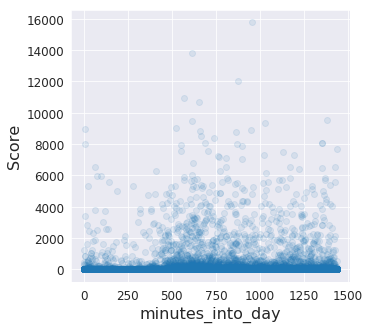

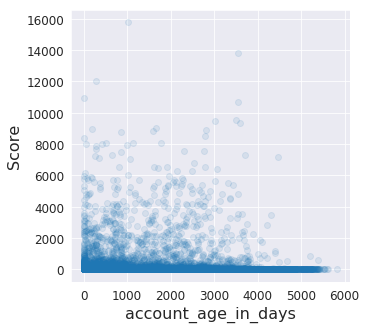

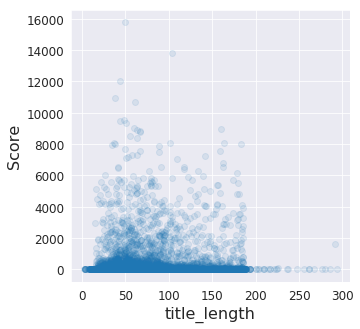

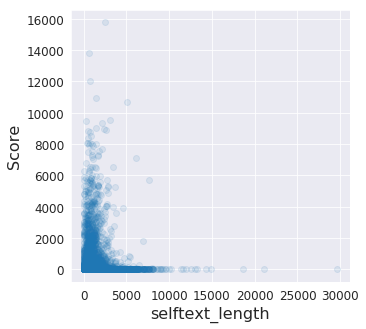

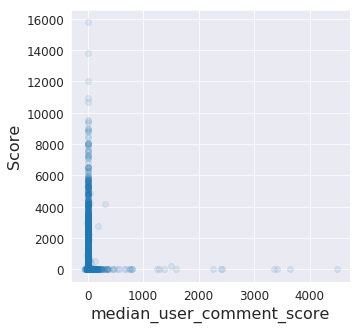

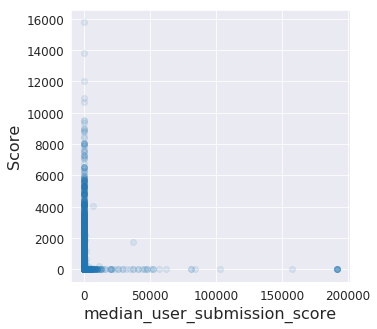

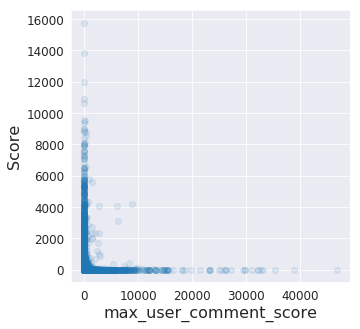

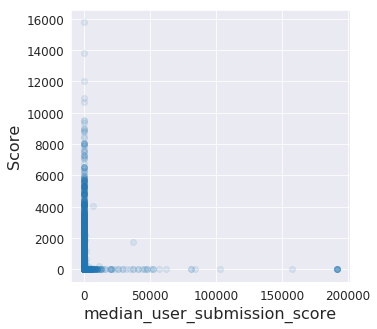

In [114]:
feature_list = ['minutes_into_day',
                'account_age_in_days', 
                'title_length', 
                'selftext_length',
                'median_user_comment_score',
                'median_user_submission_score',
                'max_user_comment_score',
                'median_user_submission_score']
for feature in feature_list:
    numerical_feature_plot(feature)

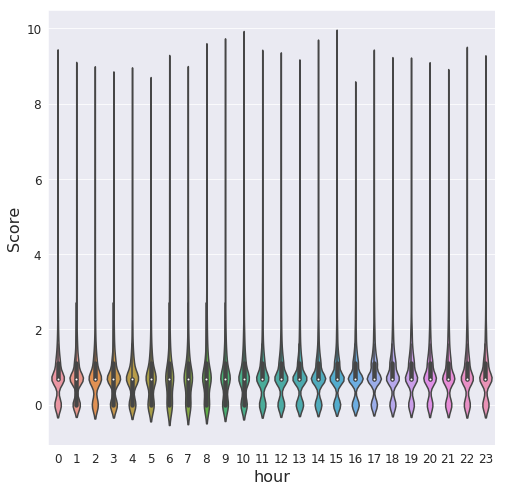

In [96]:
categorical_feature_plot('hour')

In [115]:
df.head()

,id,author,title,selftext,time,date,score,num_comments,user_account_created,num_user_comments,...,account_created_date,account_created_time,account_age_in_days,minutes_into_day,day_of_week,hour,weekday,ismorning,isweekend,log_score
0,n97ehm,weremanthing,Refinance my home to free up VA loan or wait?,First let me say thank you for looking at my p...,11:20:52,2021-05-10,1,2,1.472828e+09,94,...,2016-09-02,10:52:12,1711,680,0,11,0,False,False,0.693147
1,nzf89i,b1ackcat,Thank you for being such a great resource; you...,[removed],01:08:32,2021-06-14,1,2,1.275529e+09,0,...,2010-06-02,21:38:46,4030,68,0,1,0,False,False,0.693147
2,mxntnt,runnerup,"401k vs 457b, not sure which to max first",My work has both the 401k and 457b plans. They...,12:50:32,2021-04-24,3,7,1.255600e+09,0,...,2009-10-15,05:42:42,4209,770,5,12,5,False,True,1.386294
3,lg8t6y,Bunburier,"Student Loans, Interest Rate, and Payment Stra...",I'll be attending graduate school soon. Tuitio...,12:44:56,2021-02-09,2,2,1.500553e+09,0,...,2017-07-20,08:12:48,1300,764,1,12,1,False,False,1.098612
4,obzx08,Mxnchkinz_,What do I put under Gross Income when applying...,I'm applying for a Discover Secured Credit Car...,21:27:28,2021-07-01,0,15,1.598492e+09,29,...,2020-08-26,21:34:14,309,1287,3,21,3,False,False,0.000000


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124941 entries, 0 to 124940
Data columns (total 27 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            124941 non-null  object 
 1   author                        124941 non-null  object 
 2   title                         124941 non-null  object 
 3   selftext                      124941 non-null  object 
 4   time                          124941 non-null  object 
 5   date                          124941 non-null  object 
 6   score                         124941 non-null  int64  
 7   num_comments                  124941 non-null  int64  
 8   user_account_created          124941 non-null  float64
 9   num_user_comments             124941 non-null  int64  
 10  median_user_comment_score     124941 non-null  float64
 11  max_user_comment_score        124941 non-null  float64
 12  num_user_submissions          124941 non-nul

In [134]:
df2 = df[['title','selftext','num_user_comments','median_user_comment_score','max_user_comment_score',
         'median_user_submission_score', 'max_user_submission_score', 'title_length','selftext_length',
         'account_age_in_days', 'minutes_into_day', 'weekday', 'ismorning', 'isweekend','score','num_comments','virality_score']]

In [135]:
df2.head()

,title,selftext,num_user_comments,median_user_comment_score,max_user_comment_score,median_user_submission_score,max_user_submission_score,title_length,selftext_length,account_age_in_days,minutes_into_day,weekday,ismorning,isweekend,score,num_comments,virality_score
0,Refinance my home to free up VA loan or wait?,First let me say thank you for looking at my p...,94,1.0,1871.0,3.0,25906.0,45,1119,1711,680,0,False,False,1,2,0.199978
1,Thank you for being such a great resource; you...,[removed],0,0.0,0.0,6.0,4888.0,82,9,4030,68,0,False,False,1,2,0.199978
2,"401k vs 457b, not sure which to max first",My work has both the 401k and 457b plans. They...,0,0.0,0.0,0.0,0.0,41,576,4209,770,5,False,True,3,7,0.674514
3,"Student Loans, Interest Rate, and Payment Stra...",I'll be attending graduate school soon. Tuitio...,0,0.0,0.0,2.0,490.0,59,381,1300,764,1,False,False,2,2,0.250797
4,What do I put under Gross Income when applying...,I'm applying for a Discover Secured Credit Car...,29,1.0,3.0,1.5,42.0,64,335,309,1287,3,False,False,0,15,1.118697


In [136]:
df2.to_pickle('./data/train_full.pkl')

In [137]:
df2.iloc[76829]

title                           खुदा और मोहब्बत (khuda aur mohabbat ) सीजन 3 ए...
selftext                                                                [removed]
num_user_comments                                                               0
median_user_comment_score                                                     0.0
max_user_comment_score                                                        0.0
median_user_submission_score                                                  0.0
max_user_submission_score                                                     0.0
title_length                                                                   69
selftext_length                                                                 9
account_age_in_days                                                           964
minutes_into_day                                                              914
weekday                                                                         6
ismorning       

## Machine Learning

In [138]:
X_train = df2[['title','selftext','num_user_comments','median_user_comment_score','max_user_comment_score',
         'median_user_submission_score', 'max_user_submission_score', 'title_length','selftext_length',
         'account_age_in_days', 'minutes_into_day', 'weekday', 'ismorning', 'isweekend']]
y_train = df2['virality_score']

In [127]:
from sklearn.model_selection import train_test_split

X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train,
                                                                   test_size=.2,
                                                                   shuffle=True,
                                                                   random_state=42)

In [128]:
X_train_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99952 entries, 83941 to 121958
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   title                         99952 non-null  object 
 1   selftext                      99952 non-null  object 
 2   num_user_comments             99952 non-null  int64  
 3   median_user_comment_score     99952 non-null  float64
 4   max_user_comment_score        99952 non-null  float64
 5   median_user_submission_score  99952 non-null  float64
 6   max_user_submission_score     99952 non-null  float64
 7   title_length                  99952 non-null  int64  
 8   selftext_length               99952 non-null  int64  
 9   account_age_in_days           99952 non-null  int64  
 10  minutes_into_day              99952 non-null  int64  
 11  weekday                       99952 non-null  int64  
 12  ismorning                     99952 non-null  bool   
 

In [124]:
from sklearn.linear_model import Lasso